# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

### Code Overview
------------
1. Extract Image from Video

#### Image Process - Pipeline
1. Grayscale Conversion
2. Gaussian Smoothing
3. Canny Filter
4. Region Masking
5. Hough Filter

#### Draw Lines
1. Find Slope
2. Separate Left and Right Values
3. Generate Linear Fit
4. Extend end points to Region
5. Filter X and Y values outside image
6. Generate Line Overlay
------------

## Import Packages

In [1]:
#Importing matplotlib for plots & images, numpy & math for math expressions, and cv2 for image processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy as np
import cv2
import os
%matplotlib inline

#Import for edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read in an Image
An example of how to read & display an image from directory

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


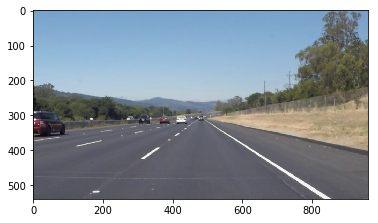

In [3]:
#Read Image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#Print some properties and diplay image
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Helper Functions

Functions provided by the ([project](https://github.com/udacity/CarND-LaneLines-P1/blob/master/P1.ipynb) )

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Introduce the "filterImg()" function.

This function's purpose is to filter raw images using an Image Processing pipeline.

The filterImg() function primarily uses OpenCV library.  Refer to the [OpenCV](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html#py-table-of-content-imgproc) Documentation for more details.

Test the pipeline on the images in the test_images folder.

In [20]:
def filterImg(img, printEnable):
    # Image Process - Pipeline¶
    # --------------------------
    # Grayscale Conversion
    # Gaussian Smoothing
    # Canny Filter
    # Region Masking
    # Hough Filter
    
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Gaussian Smoothing
    kernel_size = 11 
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Canny Filter
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Create masked edges image
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(460, 330), (520, 330), (imshape[1] - 50,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Hough Transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2                # distance resolution in pixels of the Hough grid
    theta = np.pi/180      # angular resolution in radians of the Hough grid
    threshold = 15         # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30   # minimum number of pixels making up a line
    max_line_gap = 40      # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    # Iterate over the output "lines" and draw lines on a blank image
    leftX  =  []
    rightX =  []
    leftY  =  []
    rightY =  []
    
    # Compute Slope & determine Left & Right Lanes
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1)/(x2-x1)
            # Separate Left & Right Lanes
            if m > 0:
                #rightSlope.append(m)
                rightX.append(x1)
                rightY.append(y1)
                rightX.append(x2)
                rightY.append(y2)
            elif m < 0:
                #leftSlope.append(m)
                leftX.append(x1)
                leftY.append(y1)
                leftX.append(x2)
                leftY.append(y2)
    
    # Calculate linear fit for Left & right Lanes
    zLeft  = np.polyfit(leftX, leftY, 1)
    zRight = np.polyfit(rightX, rightY, 1)
    
    # Determine endpoints for Lanes
    xMinLeft = (330-zLeft[1])/zLeft[0]
    xMaxLeft  = (imshape[0]-zLeft[1])/zLeft[0]

    xMinRight = (330-zRight[1])/zRight[0]
    xMaxRight = (imshape[0]-zRight[1])/zRight[0]
    
    # Create Left & Right Lane Overlay
    cv2.line(line_image, (int(xMinRight), 330), (int(xMaxRight), imshape[0]), (255,0,0),10)
    cv2.line(line_image, (int(xMinLeft), 330), (int(xMaxLeft), imshape[0]), (255,0,0),10)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    if(printEnable):
        #Print images
        print_img(img, gray, blur_gray, edges, masked_edges, color_edges, line_image)
    return

def print_img(img, gray, blur_gray, edges, masked_edges, color_edges, line_image):
    
    # Print Gray scale Image
    fig1 = plt.figure()
    fig1_plot = fig1.add_subplot(1,1,1)
    fig1_plot.set_title('Gray Image')
    
    plt.imshow(gray, cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

    # Print Gaussian Smoothing Image
    fig2 = plt.figure()
    fig2_plot = fig2.add_subplot(1,1,1)
    fig2_plot.set_title('Gaussian Image')
    
    plt.imshow(blur_gray, cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

    # Print Canny Filter Image
    fig3 = plt.figure()
    fig3_plot = fig3.add_subplot(1,1,1)
    fig3_plot.set_title('Canny Filter Image')
    
    plt.imshow(edges, cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

    # Print Region Masking
    fig4 = plt.figure()
    fig4_plot = fig4.add_subplot(1,1,1)
    fig4_plot.set_title('Region Masking Image')
    
    plt.imshow(masked_edges, cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')   

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    
    fig5 = plt.figure()
    fig5_plot = fig5.add_subplot(1,1,1)
    fig5_plot.set_title('Lane Image')
    
    plt.imshow(lines_edges)
    
    # Save Image
    output_image = "test_images_output/" + "filtered" + img
    plt.savefig(output_image)
    
    return

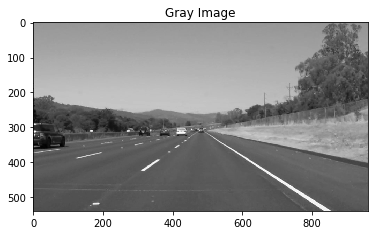

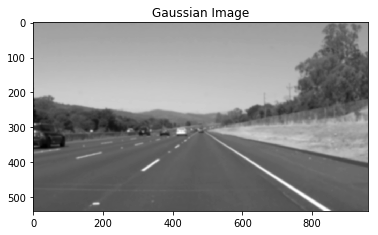

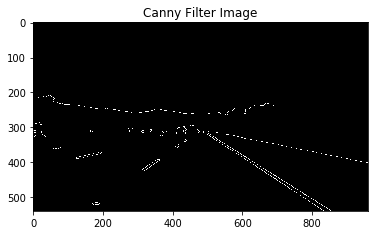

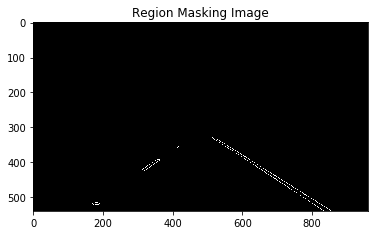

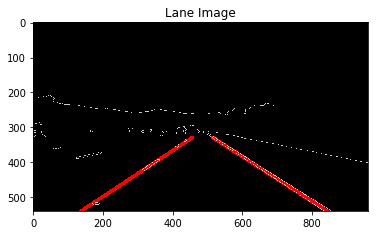

In [25]:
#Read Images
images = os.listdir("test_images/")

for i in range(len(images)):
    if(i == 0):
        filterImg(images[i], True)
    else:
        filterImg(images[i], False)


## Test on Videos

Test filter on video using the test videos folder.

In [26]:
def process_image(image):
    
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 60
    high_threshold = 180
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    #Mask
    imshape = image.shape
    vertices = np.array([[(50,imshape[0]),(450, 330), (520, 330), (imshape[1] - 50,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    leftX  =  []
    rightX =  []
    leftY  =  []
    rightY =  []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1)/(x2-x1)
            
            if m >= 0.2 and m < 0.8:
                rightX.append(x1)
                rightY.append(y1)
                rightX.append(x2)
                rightY.append(y2)
            elif m < -0.2 and m > -0.8:
                leftX.append(x1)
                leftY.append(y1)
                leftX.append(x2)
                leftY.append(y2)
    
    if not(not rightX or not leftX):
        zLeft  = np.polyfit(leftX, leftY, 1)
        zRight = np.polyfit(rightX, rightY, 1)

        xMinLeft = (330-zLeft[1])/zLeft[0]
        xMaxLeft  = (imshape[0]-zLeft[1])/zLeft[0]

        xMinRight = (330-zRight[1])/zRight[0]
        xMaxRight = (imshape[0]-zRight[1])/zRight[0]
        
        
        if ((xMinRight < imshape[1]) & (xMinRight > 0)):
            if((xMaxRight < imshape[1]) & (xMaxRight > 0)):
                cv2.line(line_image, (int(xMinRight), 330), (int(xMaxRight), imshape[0]), (255,0,0),10)
            
        if ((xMinLeft < imshape[1]) & (xMinLeft > 0)):
            if ((xMaxLeft < imshape[1]) & (xMaxLeft > 0)):
                cv2.line(line_image, (int(xMinLeft), 330), (int(xMaxLeft), imshape[0]), (255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    
    result = lines_edges

    return result

Let's try the one with the solid white lane on the right first ...

In [27]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 59.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.24 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [29]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 59.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 12.1 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Modified image processing code for Challenge

In [32]:
def process_image(image):
    
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 9
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and apply
    low_threshold = 30
    high_threshold = 90
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    #Mask
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]- 75),(635, 440), (650, 440), (imshape[1] - 50,imshape[0] -75)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 18     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 35 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    leftX  =  []
    rightX =  []
    leftY  =  []
    rightY =  []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1)/(x2-x1)

            if m >= 0.2 and m < 0.8:
                rightX.append(x1)
                rightY.append(y1)
                rightX.append(x2)
                rightY.append(y2)
            elif m <= -0.2 and m > -0.8:
                leftX.append(x1)
                leftY.append(y1)
                leftX.append(x2)
                leftY.append(y2)

    if not(not rightX or not leftX):
        zLeft  = np.polyfit(leftX, leftY, 1)
        zRight = np.polyfit(rightX, rightY, 1)

        xMinLeft = (440-zLeft[1])/zLeft[0]
        xMaxLeft  = (imshape[0]-zLeft[1])/zLeft[0]

        xMinRight = (440-zRight[1])/zRight[0]
        xMaxRight = (imshape[0]-zRight[1])/zRight[0]
    
        if ((xMinRight < imshape[1]) & (xMinRight > 0)):
            if((xMaxRight < imshape[1]) & (xMaxRight > 0)):
                cv2.line(line_image, (int(xMinRight), 440), (int(xMaxRight), imshape[0]), (255,0,0),10)
            
        if ((xMinLeft < imshape[1]) & (xMinLeft > 0)):
            if ((xMaxLeft < imshape[1]) & (xMaxLeft > 0)):
                cv2.line(line_image, (int(xMinLeft), 440), (int(xMaxLeft), imshape[0]), (255,0,0),10)
    
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    
    result = lines_edges

    return result

In [33]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:08<00:00, 29.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 9.51 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))